# Collective Effects - Bipolar Isotropic Gas with Spectrum

In [2]:
#Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import scipy.integrate as integrate
import math 
from ipywidgets import interact, interactive, fixed, interact_manual
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.animation import FuncAnimation
from scipy.special import gamma

from matplotlib import animation, rc
from IPython.display import HTML

In [3]:
G_F=1.1663787*10**(-23) #eV⁻² - Fermi Constant
delta_m2_31=2.5*10**(-3) #eV² - \Delta m²_31
#theta_31=np.arcsin(math.sqrt(2.18*10**-2)) #\theta_31
theta_31=10**(-2)#\theta_31
N_A=6.02*10**(23) #Avogadro constant
from_eV_to_1_over_m=8.065543937*10**5
from_eV_to_1_over_km=from_eV_to_1_over_m*10**(3)

#Calculate the effective mass squared difference in matter
def delta_m2_eff(delta_m2,theta,Acc):
  delta = math.sqrt((delta_m2*np.cos(2*theta)-Acc)**2+(delta_m2*np.sin(2*theta))**2)
  return delta

#Calculate the effective mixing angle in matter
def theta_eff(delta_m2,theta,Acc):
  theta_eff=(1/2)*math.atan2(1,1/((math.tan(2*theta))/(1-(Acc/(delta_m2*np.cos(2*theta))))))
  return theta_eff

#Calculate the matter "Potential" - Acc=2EV_cc
def Acc(N_e,E):
  A = 2*math.sqrt(2)*E*G_F*N_e
  return A

def B_vec(E):
  E=E*10**6 #From MeV to eV
  B=delta_m2_31/(2*E)
  B1=B*np.sin(2*theta_31)
  B2=0
  B3=B*np.cos(2*theta_31)
  return B,B1,B2,B3

In [33]:
def phi(E,E_0,alpha):
  N=((alpha+1)**(alpha+1))/(E_0*gamma(alpha+1))
  R=N*((E/E_0)**alpha)*math.exp((-1)*(alpha+1)*E/E_0)
  return R
phi_vec= np.vectorize(phi)

#Neutrino potential
def mu_supernova(r,mu_0): # r in eV⁻¹
  R_0=4*10**4#m
  R_0= R_0*(8*10**5) #eV⁻¹
  if r<R_0:
    return mu_0
  return mu_0*(R_0/r)**4
mu_supernova_vec=np.vectorize(mu_supernova)

In [10]:
#Energy
E_step=0.1
E_vec=np.arange(1,50,E_step)
n_E=len(E_vec)

#Flavors of Neutrino
nu_types=['nu_e','nu_x']
n_f=len(nu_types)
n_dim=(n_f**2)-1

#Number of first-order ODEs
N=2*n_f*n_dim*n_E

print(n_f,n_dim,n_E,N)

2 3 490 5880


In [34]:
#Initial spectrum
nu_types=['nu_e','nu_x']
E_0=[10,15,24,24] #Mean energy in MeV
Amplitude=[1,1,1,1]

y0=[] #Initial state
B1,B2,B3=[],[],[]
B=[]
flavor_sign=1

for i in range(n_E):      
  B1.append(B_vec(E_vec[i])[1])
  B2.append(B_vec(E_vec[i])[2])
  B3.append(B_vec(E_vec[i])[3])
  B.append([B_vec(E_vec[i])[1],B_vec(E_vec[i])[2],B_vec(E_vec[i])[3]])
    
  for j in range(n_f):
    if nu_types[j]=="nu_x":
      flavor_sign=-1
    if nu_types[j]=="nu_e":
      flavor_sign=1
    #nu
    nu_spec=Amplitude[n_f*j]*phi_vec(E_vec[i],E_0[n_f*j+1],2.3)*E_step
    y0.append(0)
    y0.append(0)
    y0.append(flavor_sign*nu_spec)
    #nubar
    nu_spec=Amplitude[n_f*j+1]*phi_vec(E_vec[i],E_0[n_f*j+1],2.3)*E_step
    y0.append(0)
    y0.append(0)
    y0.append(flavor_sign*nu_spec)

In [37]:
#time
t_bins=1000
t_max = 4*(2*np.pi/min(B_vec(E_vec)[0])) #eV⁻¹
t_step = (2*np.pi/max(B_vec(E_vec)[0]))/20 #eV⁻¹
t_vec = np.arange(0., t_bins*t_step , t_step) #eV⁻¹

#mu
mu_0=(10)*max(B_vec(E_vec)[0])

In [38]:
def structure_constant(n_f,i,j,k):
    if i==j or i==k or j==k:
        return 0
    if n_f==3:
        i_next=(i+1)%3
        if  i_next == j:
            return 1
        if i_next == k:
            return -1 
    else:
        print("Dimension not defined")

def cross_prod(A,B,i,n_dim):
    sum=0
    for j in range(n_dim):
        for k in range(n_dim):
            sum=structure_constant(n_dim,i,j,k)*A[j]*B[k]
    return sum

In [46]:
def func_Collective_nu(y, time, params):
    B= params  # unpack parameters
    mu=mu_supernova_vec(time,mu_0)
    derivs=[]
    nu, nubar = [],[]
    num_diff_nu_compnents=2*n_f*n_dim
    
    #Filling [Nu_types][3components] arrays with [Energy bin]
    for i in range(n_E):
      nu.append([])
      nubar.append([])
      for j in range(n_f):
        nu[i].append([])
        nubar[i].append([])
        for k in range(n_dim):
          #nu 
          nu_index=(i*num_diff_nu_compnents)+k+2*j*n_dim
          nu[i][j].append(y[nu_index])
          #nubar   
          nubar_index=(i*num_diff_nu_compnents)+(k+n_dim)+2*j*n_dim
          nubar[i][j].append(y[nubar_index])
    
    #Summed nu and nubar components
    nu_sum, nubar_sum=[],[]
    for i in range(n_dim):
      nu_sum.append(sum(map(sum, np.transpose(nu,(2,0,1))[i])))
      nubar_sum.append(sum(map(sum, np.transpose(nubar,(2,0,1))[i])))
    
    B=np.array(B)
    nu_sum=np.array(nu_sum)
    nubar_sum=np.array(nubar_sum)
    # list of dy/dt=f functions
    for i in range(n_E):
      for j in range(n_f):
        for k in range(n_dim):
          #nu 
          P_aux= cross_prod(nu[i][j],(B[i]+mu*(nu_sum-nubar_sum)),k,n_dim)
          derivs.append(P_aux)
        for k in range(n_dim):
          #nubar
          P_aux= cross_prod(nu[i][j],(-1*B[i]+mu*(nu_sum-nubar_sum)),k,n_dim)
          derivs.append(P_aux)

    return derivs

In [54]:
psoln_nu_x_NH= odeint(func_Collective_nu, y0, t_vec, args=(B,))
psoln_nu_x_IH= odeint(func_Collective_nu, y0, t_vec, args=(-1*np.array(B),))

# Corrigir Leitura

In [55]:
def read_output(psoln):
  space_dim=3
  num_of_nus=len(nu_types)  
  print("Num of nus",num_of_nus)
  num_E_bins=int(len(psoln[0])/(2*space_dim*num_of_nus))
  print("Num of E bins",num_E_bins)

  nu,nubar=[],[]
  for l in range(space_dim):
    nu.append([])
    nubar.append([])
    for k in range(num_of_nus):
      nu[l].append([])
      nubar[l].append([])
      for j in range(len(psoln)):
        nu[l][k].append([])
        nubar[l][k].append([])
        for i in range(num_E_bins):
          nu[l][k][j].append(psoln[j][(i*2*space_dim*num_of_nus)+l+k*2*space_dim])
          nubar[l][k][j].append(psoln[j][(i*2*space_dim*num_of_nus)+l+3+k*2*space_dim])

  return nu, nubar #[Pauli Matrix][Nu_type][time][energy]

def read_flavor(nu, nubar):
  nu_e_time,nubar_e_time=[],[]
  nu_x_time,nubar_x_time=[],[]

  for l in range(len(nu_NH[0][0])): #time array length
      nu_e_time.append([])
      nubar_e_time.append([])
      nu_x_time.append([])
      nubar_x_time.append([])
      for i in range(len(nu_NH[0][0][0])): 
        #nu
        P3_x,P3_e=0,0
        if nu[2][0][l][i]>0:
          P3_e=P3_e+nu[2][0][l][i]
        else:
          P3_x=P3_x+nu[2][0][l][i]

        if nu[2][1][l][i]>0:
          P3_e=P3_e+nu[2][1][l][i]
        else:
          P3_x=P3_x+nu[2][1][l][i]

        nu_e_time[l].append(P3_e)
        nu_x_time[l].append(-1*P3_x)

        #nubar
        P3_x,P3_e=0,0
        if nubar[2][0][l][i]>0:
          P3_e=P3_e+nubar[2][0][l][i]
        else:
          P3_x=P3_x+nubar[2][0][l][i]

        if nubar[2][1][l][i]>0:
          P3_e=P3_e+nubar[2][1][l][i]
        else:
          P3_x=P3_x+nubar[2][1][l][i]

        nubar_e_time[l].append(P3_e)
        nubar_x_time[l].append(-1*P3_x)

  return   nu_e_time,nubar_e_time, nu_x_time,nubar_x_time

In [56]:
#NH
nu_NH, nubar_NH= read_output(psoln_nu_x_NH)
nu_e_time_NH,nubar_e_time_NH, nu_x_time_NH,nubar_x_time_NH=read_flavor(nu_NH, nubar_NH)
#IH
nu_IH, nubar_IH= read_output(psoln_nu_x_IH)
nu_e_time_IH,nubar_e_time_IH, nu_x_time_IH,nubar_x_time_IH=read_flavor(nu_IH, nubar_IH)

Num of nus 2
Num of E bins 490
Num of nus 2
Num of E bins 490


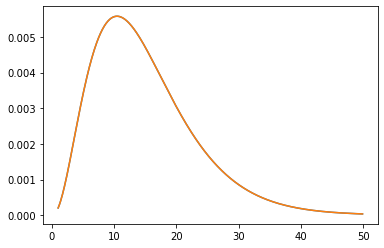

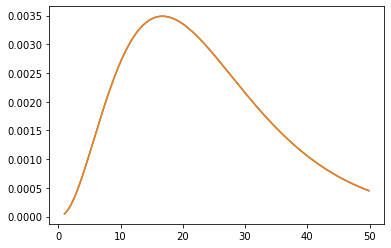

In [57]:
plt.figure()
plt.plot(E_vec,nubar_e_time_IH[0])
plt.plot(E_vec,nubar_e_time_IH[500])

plt.figure()
plt.plot(E_vec,nubar_x_time_IH[0])
plt.plot(E_vec,nubar_x_time_IH[500])

/home/pedro/anaconda3/lib/python3.9/site-packages/matplotlib/animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


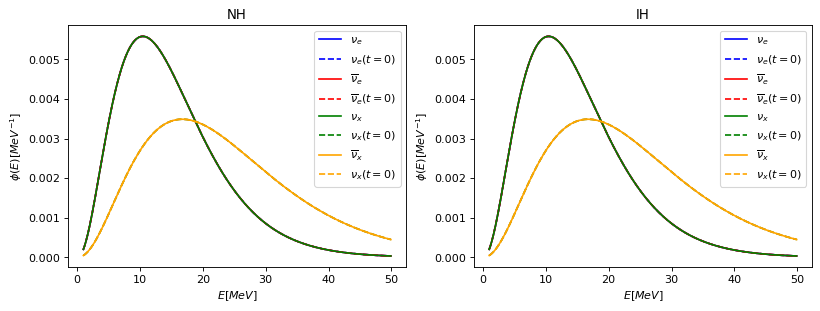

In [58]:
t_step=10
t_f=len(t_vec)

fig = plt.figure(figsize=(12, 4), dpi= 80, facecolor='w', edgecolor='k')
#fig, ax = plt.subplots()
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlabel(r'$E [MeV]$')
ax1.set_ylabel(r'$\phi(E) [MeV^{-1}]$')
#nu_e
nu_NH_line, = ax1.plot(E_vec, nu_e_time_NH[0],color='b',label=r'$\nu_e$')
ax1.plot(E_vec, nu_e_time_NH[0],color='b', linestyle="--",label=r'$\nu_e(t=0)$')#Initial
antinu_NH_line, = ax1.plot(E_vec,nubar_e_time_NH[0],color='r',label=r'$\overline{\nu}_e$')
ax1.plot(E_vec, nubar_e_time_NH[0],color='r', linestyle="--",label=r'$\overline{\nu}_e(t=0)$')#Initial
#nu_x
nu_x_NH_line, = ax1.plot(E_vec,nu_e_time_NH[0],color='g',label=r'$\nu_x$')
ax1.plot(E_vec, nu_x_time_NH[0],color='g', linestyle="--",label=r'$\nu_x(t=0)$')#Initial
antinu_x_NH_line, = ax1.plot(E_vec,nubar_x_time_NH[0],color='orange',label=r'$\overline{\nu}_x$')
ax1.plot(E_vec, nubar_x_time_NH[0],color='orange', linestyle="--",label=r'$\nu_x(t=0)$')#Initial
#ax1.set_ylim(0,0.07)
ax1.set_title("NH")
ax1.legend(loc='upper right')

#IH
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlabel(r'$E [MeV]$')
ax2.set_ylabel(r'$\phi(E) [MeV^{-1}]$')
#nu_e
nu_IH_line, = ax2.plot(E_vec, nu_e_time_IH[0],color='b',label=r'$\nu_e$')
ax2.plot(E_vec, nu_e_time_IH[0],color='b', linestyle="--",label=r'$\nu_e(t=0)$')#Initial
antinu_IH_line, = ax2.plot(E_vec,nubar_e_time_IH[0],color='r',label=r'$\overline{\nu}_e$')
ax2.plot(E_vec, nubar_e_time_IH[0],color='r', linestyle="--",label=r'$\overline{\nu}_e(t=0)$')#Initial
#nu_x
nu_x_IH_line, = ax2.plot(E_vec,nu_e_time_IH[0],color='g',label=r'$\nu_x$')
ax2.plot(E_vec, nu_x_time_IH[0],color='g', linestyle="--",label=r'$\nu_x(t=0)$')#Initial
antinu_x_IH_line, = ax2.plot(E_vec,nubar_x_time_IH[0],color='orange',label=r'$\overline{\nu}_x$')
ax2.plot(E_vec, nubar_x_time_IH[0],color='orange', linestyle="--",label=r'$\nu_x(t=0)$')#Initial
#ax2.set_ylim(0,0.07)
ax2.set_title("IH")
ax2.legend(loc='upper right')

def update(t_i):
    #NH
    nu_NH_line.set_data(E_vec,nu_e_time_NH[t_i])
    antinu_NH_line.set_data(E_vec,nubar_e_time_NH[t_i])
    nu_x_NH_line.set_data(E_vec,nu_x_time_NH[t_i])
    antinu_x_NH_line.set_data(E_vec,nubar_x_time_NH[t_i])
    #IH
    nu_IH_line.set_data(E_vec,nu_e_time_IH[t_i])
    antinu_IH_line.set_data(E_vec,nubar_e_time_IH[t_i])
    nu_x_IH_line.set_data(E_vec,nu_x_time_IH[t_i])
    antinu_x_IH_line.set_data(E_vec,nubar_x_time_IH[t_i])

    #ax.set_title('Spectrum (10kpc)- t=%f s'%(t_data[0][t_i]))
    #max=np.amax(phi_aux)
    #ax.set_ylim(0, max)
    #print(max)

ani = FuncAnimation(fig, update, frames=np.arange(0,t_f,t_step), interval=100)


In [59]:
HTML(ani.to_html5_video())

OSError: [Errno 12] Cannot allocate memory